In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from Elrond.Helpers.array_utility import pandas_collumn_to_2d_numpy_array
from scipy.signal import spectrogram, welch
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import pynapple as nap
from scipy.ndimage import gaussian_filter, rotate
from scipy.signal import find_peaks, peak_prominences, spectrogram
from scipy.stats import zscore
import scipy 
from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session
from spatial_manifolds.util import gaussian_filter_nan
from spatial_manifolds.circular_decoder import circular_decoder, cross_validate_decoder
import seaborn as sns
from scipy.stats import norm


import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/sm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def wrap_list(obj):
    return obj if isinstance(obj, list | tuple) else [obj]


def compute_travel_projected(var_label, var_values, P, travel):
    n = len(P)

    # Compute cumulative distances based on dimensionality
    if P.ndim == 1:
        segment_lengths = np.abs(np.diff(P))
    else:
        deltas = np.diff(P, axis=0)
        segment_lengths = np.linalg.norm(deltas, axis=1)

    cum_distances = np.insert(np.cumsum(segment_lengths), 0, 0)

    projected_vals = []
    valid_times = []
    j = 0
    times = P.times()

    for i in range(n):
        target_distance = cum_distances[i] + travel

        # Advance j until we find the segment that contains the projected distance
        while j < n and cum_distances[j] < target_distance:
            j += 1

        if j >= n:
            break  # Stop if out of bounds

        d1 = cum_distances[j - 1]
        d2 = cum_distances[j]
        t = (target_distance - d1) / (d2 - d1)

        interp_val = var_values[j - 1] + t * (
            var_values[j] - var_values[j - 1]
        )

        projected_vals.append(interp_val)
        valid_times.append(times[i])

    projected_vals = np.array(projected_vals)
    valid_times = np.array(valid_times)

    return nap.TsdFrame(
        t=valid_times, d=projected_vals, columns=wrap_list(var_label)
    )

In [3]:
mouse = 25
day =  25
session = 'OF1'

of1_folder = f'/Users/harryclark/Downloads/COHORT12_nwb/M{mouse}/D{day:02}/{session}/'
grid_path = of1_folder + "tuning_scores/grid_score.parquet"
shifted_grid_path = of1_folder + "tuning_scores/shifted_grid_score.parquet"
spikes_path = of1_folder + f"sub-{mouse}_day-{day:02}_ses-{session}_srt-kilosort4_clusters.npz"
beh_path = of1_folder + f"sub-{mouse}_day-{day:02}_ses-{session}_beh.nwb"
active_projects_path = Path("/Volumes/cmvm/sbms/groups/CDBS_SIDB_storage/NolanLab/ActiveProjects/")
anatomy_path = active_projects_path / "Chris/Cohort12/derivatives/labels/anatomy/cluster_annotations.csv"
cluster_locations = pd.read_csv(anatomy_path)
beh = nap.load_file(beh_path)
clusters = nap.load_file(spikes_path)
shifted_grid_scores = pd.read_parquet(shifted_grid_path)
grid_cells = shifted_grid_scores.query('sig == True and travel == 0')
non_grid_cells = shifted_grid_scores.query('sig == False and travel == 0')
mouseday_cluster_locations = cluster_locations.query(f'mouse == {mouse} & day == {day}')


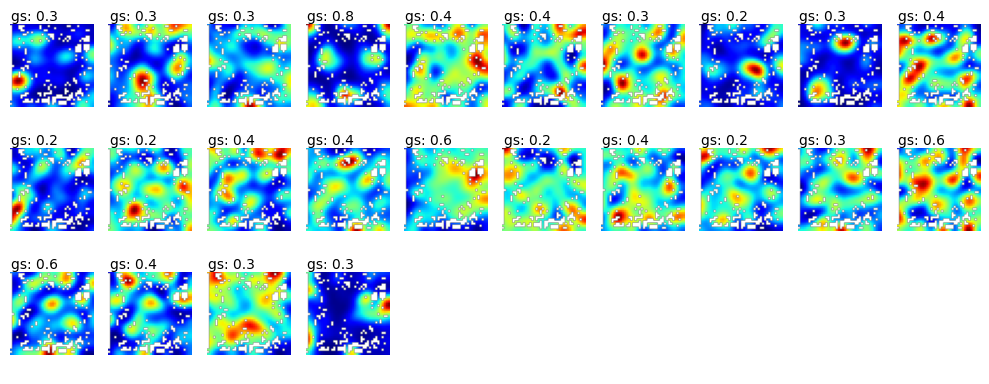

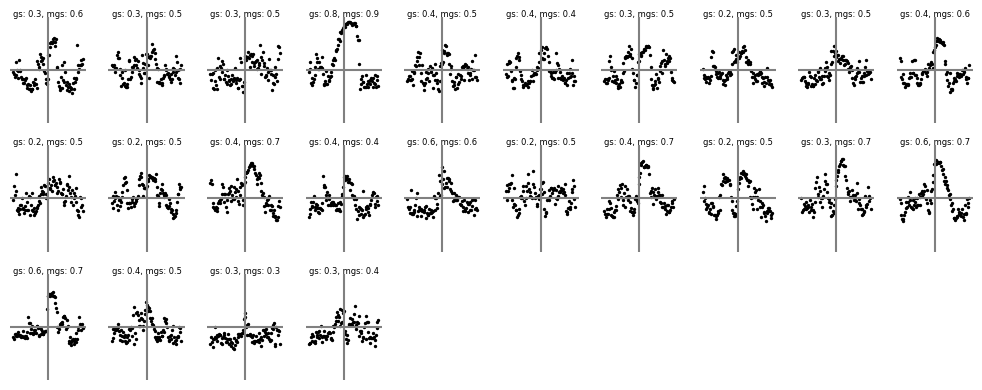

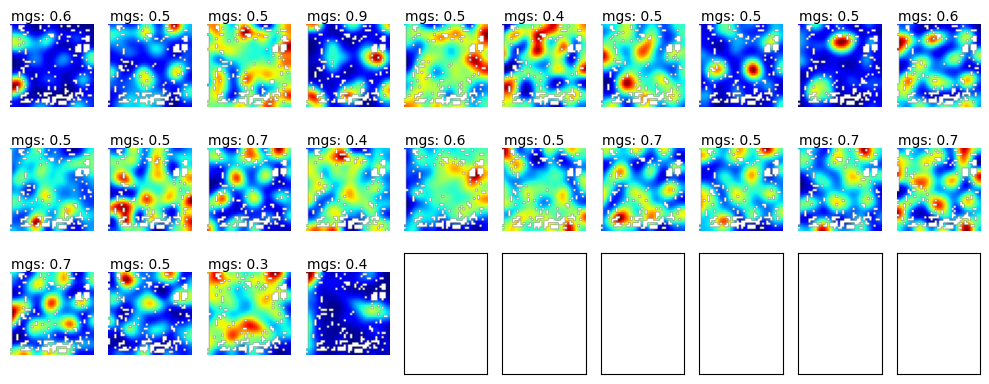

In [7]:
tcs = {}
position = np.stack([beh['P_x'], beh['P_y']], axis=1)
for cell in grid_cells['cluster_id'].values:
    tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters[cell]]), position, nb_bins=(40,40))[0]
    tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
    tcs[cell] = tc
 
ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 4*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            index = grid_cells['cluster_id'].values[counter]
            score = grid_cells['grid_score'].values[counter]
            ax[j, i].text(0,-2, f'gs: {np.round(score, decimals=1)}')
            ax[j, i].imshow(tcs[index], cmap='jet')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        counter+=1
plt.tight_layout()
plt.show()


ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 4), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(grid_cells['cluster_id']):
            index = grid_cells['cluster_id'].values[counter]
            score = grid_cells['grid_score'].values[counter]

            cluster_shifted_grid_scores = shifted_grid_scores[shifted_grid_scores.cluster_id==index]
            max_score = np.nanmax(cluster_shifted_grid_scores.grid_score)

            percentile95 = np.nanpercentile(cluster_shifted_grid_scores.null_distribution.iloc[0], 95)
            percentile99 = np.nanpercentile(cluster_shifted_grid_scores.null_distribution.iloc[0], 99)
            max_percentile95 = np.nanpercentile(cluster_shifted_grid_scores.max_null_distribution.iloc[0], 95)
            max_percentile99 = np.nanpercentile(cluster_shifted_grid_scores.max_null_distribution.iloc[0], 99)
            percentile95_2 = norm.ppf(0.95,loc=np.nanmean(cluster_shifted_grid_scores.null_distribution.iloc[0]),scale=np.nanstd(cluster_shifted_grid_scores.null_distribution.iloc[0]))
            percentile99_2 = norm.ppf(0.99,loc=np.nanmean(cluster_shifted_grid_scores.null_distribution.iloc[0]),scale=np.nanstd(cluster_shifted_grid_scores.null_distribution.iloc[0]))
            max_percentile95_2 = norm.ppf(0.95,loc=np.nanmean(cluster_shifted_grid_scores.max_null_distribution.iloc[0]),scale=np.nanstd(cluster_shifted_grid_scores.max_null_distribution.iloc[0]))
            max_percentile99_2 = norm.ppf(0.99,loc=np.nanmean(cluster_shifted_grid_scores.max_null_distribution.iloc[0]),scale=np.nanstd(cluster_shifted_grid_scores.max_null_distribution.iloc[0]))

            ax[j, i].axvline(0, color='grey')
            ax[j, i].axhline(0, color='grey')
            #ax[j, i].axhline(percentile95, color='red', linestyle='dashed', linewidth=0.5)
            #ax[j, i].axhline(percentile99, color='red', linestyle='solid', linewidth=0.5)
            #ax[j, i].axhline(max_percentile95, color='blue', linestyle='dashed', linewidth=0.5)
            #ax[j, i].axhline(max_percentile99, color='blue', linestyle='solid', linewidth=0.5)

            #ax[j, i].axhline(percentile95_2, color='red', linestyle='dashed', linewidth=0.5)
            #ax[j, i].axhline(percentile99_2, color='red', linestyle='solid', linewidth=0.5)
            #ax[j, i].axhline(max_percentile95_2, color='blue', linestyle='dashed', linewidth=0.5)
            #ax[j, i].axhline(max_percentile99_2, color='blue', linestyle='solid', linewidth=0.5)

            ax[j, i].scatter(cluster_shifted_grid_scores.travel, cluster_shifted_grid_scores.grid_score, s=2, color='black')            
            ax[j, i].text(-50,1, f'gs: {np.round(score, decimals=1)}, mgs: {np.round(max_score, decimals=1)}', size=6)

        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].set_ylim([-1,1])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        counter+=1
plt.tight_layout()
plt.show()

 
ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 4*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            index = grid_cells['cluster_id'].values[counter]
            score = grid_cells['grid_score'].values[counter]
            cluster_shifted_grid_scores = shifted_grid_scores[shifted_grid_scores.cluster_id==index]
            travel = cluster_shifted_grid_scores.travel.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
            max_score = cluster_shifted_grid_scores.grid_score.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]

            tcs = {}
            beh_lag = compute_travel_projected(["P_x", "P_y"], position, position, travel)
            position_lagged = np.stack([beh_lag['P_x'], beh_lag['P_y']], axis=1)

            for cell in grid_cells['cluster_id'].values:
                tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters[cell]]), position_lagged, nb_bins=(40,40))[0]
                tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
                tcs[cell] = tc

            index = grid_cells['cluster_id'].values[counter]
            score = grid_cells['grid_score'].values[counter]
            ax[j, i].text(0,-2, f'mgs: {np.round(max_score, decimals=1)}')
            ax[j, i].imshow(tcs[index], cmap='jet')
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['bottom'].set_visible(False)
            ax[j, i].spines['left'].set_visible(False)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()




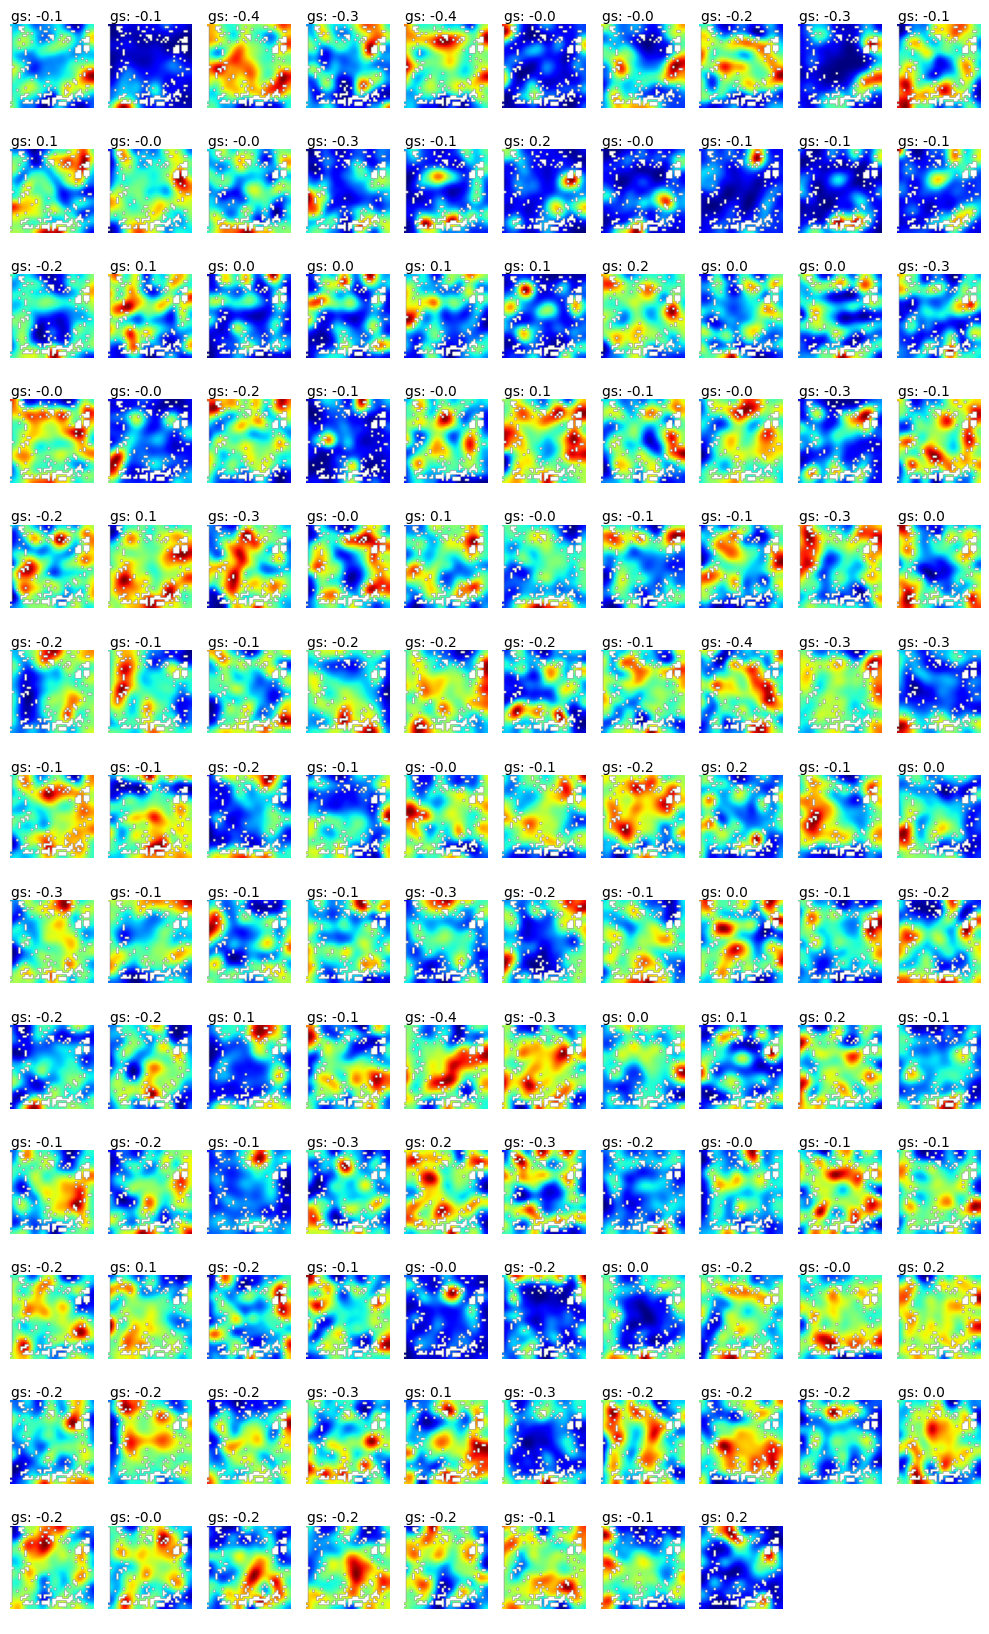

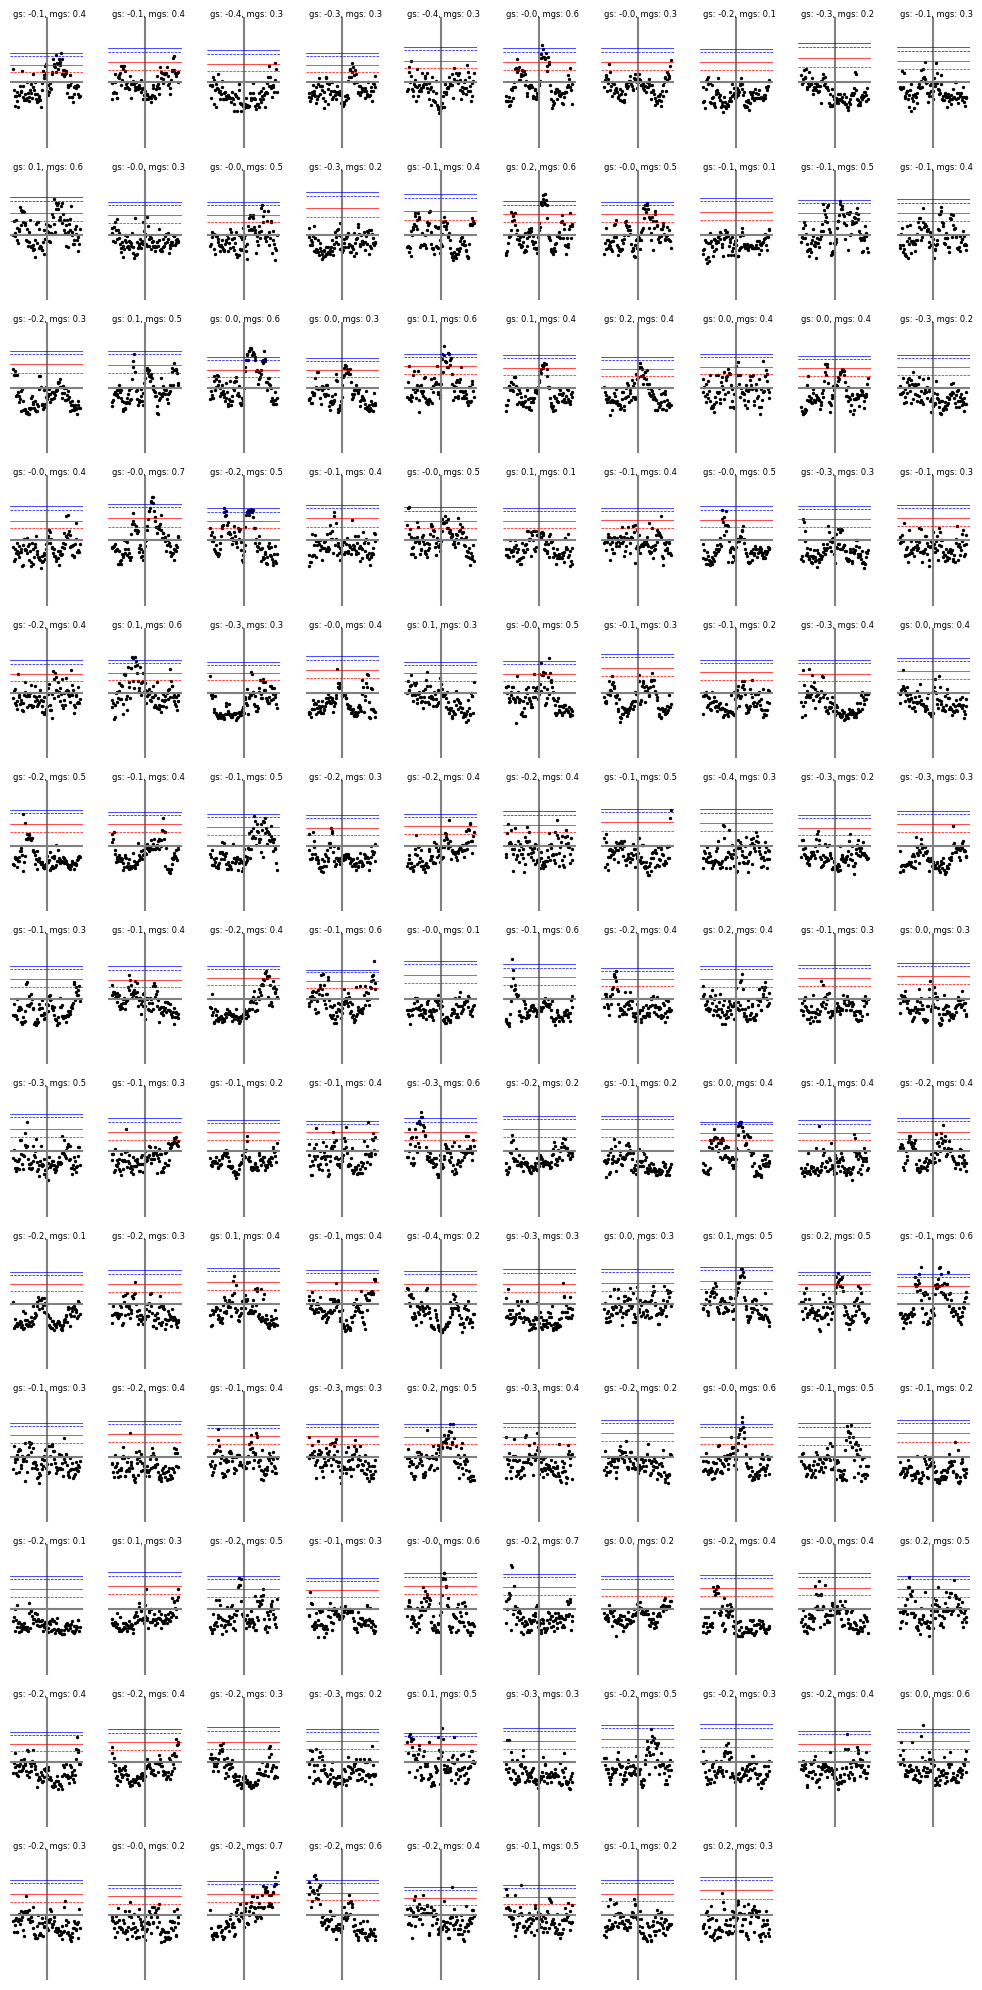

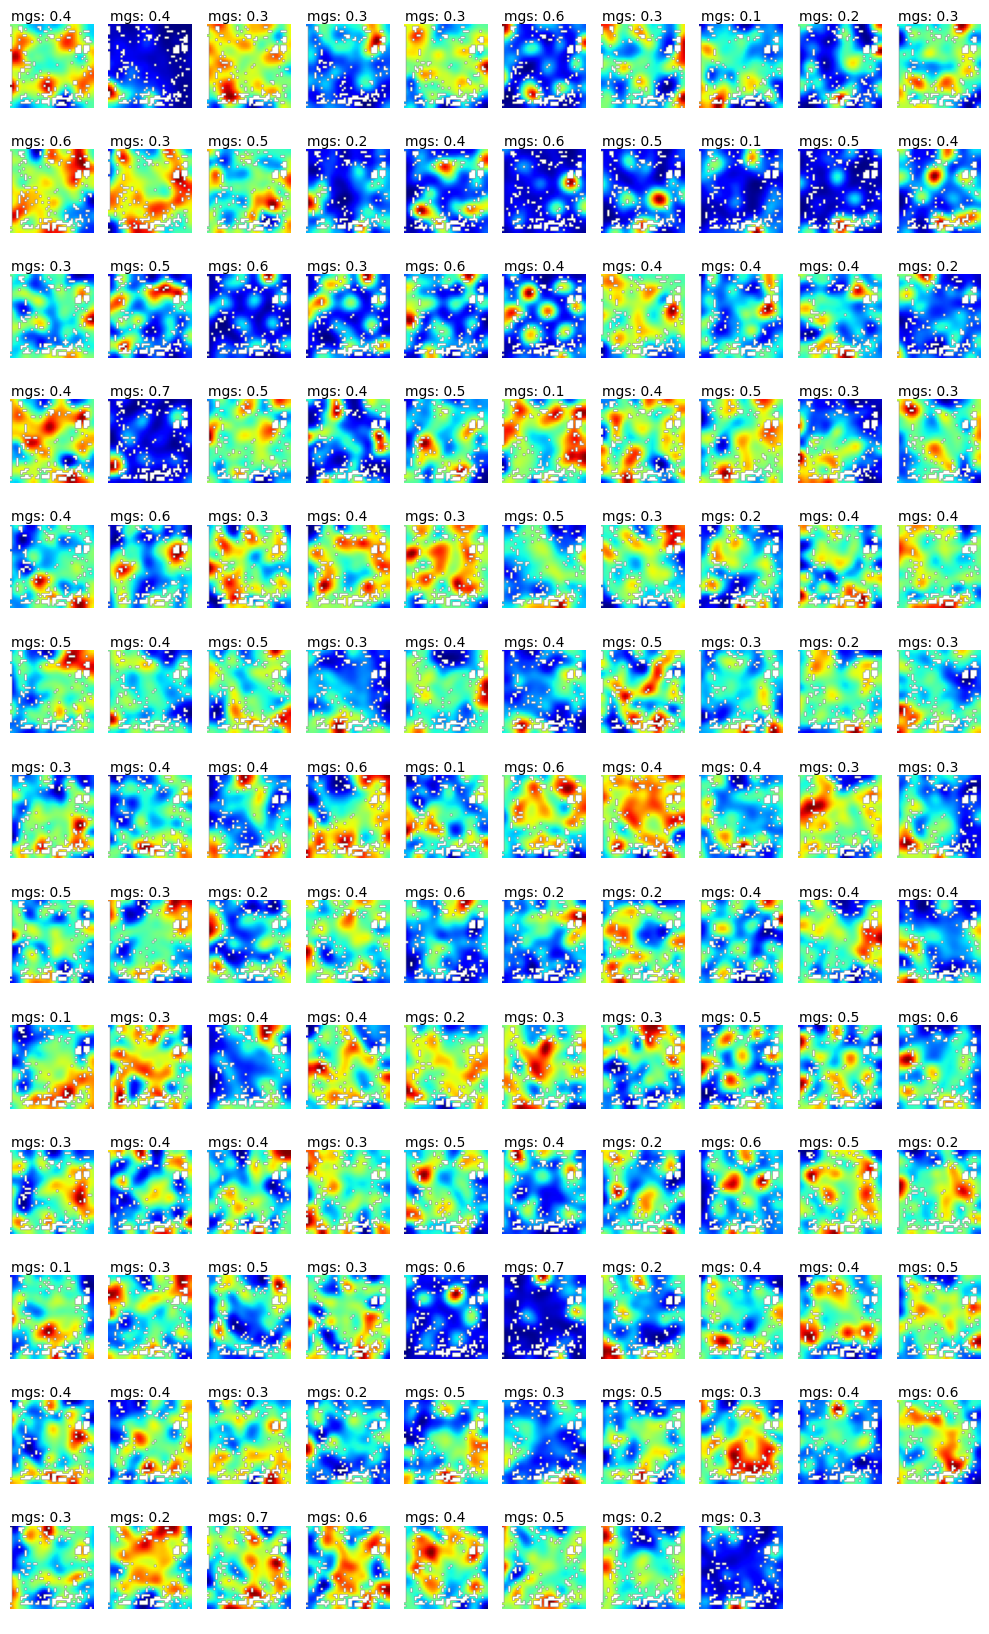

In [6]:
tcs = {}
position = np.stack([beh['P_x'], beh['P_y']], axis=1)
for cell in non_grid_cells['cluster_id'].values:
    tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters[cell]]), position, nb_bins=(40,40))[0]
    tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
    tcs[cell] = tc
 
ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            index = non_grid_cells['cluster_id'].values[counter]
            score = non_grid_cells['grid_score'].values[counter]
            ax[j, i].text(0,-2, f'gs: {np.round(score, decimals=1)}')
            ax[j, i].imshow(tcs[index], cmap='jet')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        counter+=1
plt.tight_layout()
plt.show()


ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 20), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(non_grid_cells['cluster_id']):
            index = non_grid_cells['cluster_id'].values[counter]
            score = non_grid_cells['grid_score'].values[counter]

            cluster_shifted_grid_scores = shifted_grid_scores[shifted_grid_scores.cluster_id==index]
            percentile95 = np.nanpercentile(cluster_shifted_grid_scores.null_distribution.iloc[0], 95)
            percentile99 = np.nanpercentile(cluster_shifted_grid_scores.null_distribution.iloc[0], 99)
            max_percentile95 = np.nanpercentile(cluster_shifted_grid_scores.max_null_distribution.iloc[0], 95)
            max_percentile99 = np.nanpercentile(cluster_shifted_grid_scores.max_null_distribution.iloc[0], 99)

            percentile95_2 = norm.ppf(0.95,loc=np.nanmean(cluster_shifted_grid_scores.null_distribution.iloc[0]),scale=np.nanstd(cluster_shifted_grid_scores.null_distribution.iloc[0]))
            percentile99_2 = norm.ppf(0.99,loc=np.nanmean(cluster_shifted_grid_scores.null_distribution.iloc[0]),scale=np.nanstd(cluster_shifted_grid_scores.null_distribution.iloc[0]))
            max_percentile95_2 = norm.ppf(0.95,loc=np.nanmean(cluster_shifted_grid_scores.max_null_distribution.iloc[0]),scale=np.nanstd(cluster_shifted_grid_scores.max_null_distribution.iloc[0]))
            max_percentile99_2 = norm.ppf(0.99,loc=np.nanmean(cluster_shifted_grid_scores.max_null_distribution.iloc[0]),scale=np.nanstd(cluster_shifted_grid_scores.max_null_distribution.iloc[0]))

            ax[j, i].axvline(0, color='grey')
            ax[j, i].axhline(0, color='grey')
            #ax[j, i].axhline(percentile95, color='red', linestyle='dashed', linewidth=0.5)
            #ax[j, i].axhline(percentile99, color='red', linestyle='solid', linewidth=0.5)
            #ax[j, i].axhline(max_percentile95, color='blue', linestyle='dashed', linewidth=0.5)
            #ax[j, i].axhline(max_percentile99, color='blue', linestyle='solid', linewidth=0.5)

            ax[j, i].axhline(percentile95_2, color='red', linestyle='dashed', linewidth=0.5)
            ax[j, i].axhline(percentile99_2, color='red', linestyle='solid', linewidth=0.5)
            ax[j, i].axhline(max_percentile95_2, color='blue', linestyle='dashed', linewidth=0.5)
            ax[j, i].axhline(max_percentile99_2, color='blue', linestyle='solid', linewidth=0.5)

            ax[j, i].scatter(cluster_shifted_grid_scores.travel, cluster_shifted_grid_scores.grid_score, s=2, color='black')
            max_score = np.nanmax(cluster_shifted_grid_scores.grid_score)
            
            ax[j, i].text(-50,1, f'gs: {np.round(score, decimals=1)}, mgs: {np.round(max_score, decimals=1)}', size=6)

        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].set_ylim([-1,1])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        counter+=1
plt.tight_layout()
plt.show()

 
ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            index = non_grid_cells['cluster_id'].values[counter]
            score = non_grid_cells['grid_score'].values[counter]
            cluster_shifted_grid_scores = shifted_grid_scores[shifted_grid_scores.cluster_id==index]
            travel = cluster_shifted_grid_scores.travel.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]
            max_score = cluster_shifted_grid_scores.grid_score.values[np.nanargmax(cluster_shifted_grid_scores.grid_score)]

            tcs = {}
            beh_lag = compute_travel_projected(["P_x", "P_y"], position, position, travel)
            position_lagged = np.stack([beh_lag['P_x'], beh_lag['P_y']], axis=1)

            for cell in non_grid_cells['cluster_id'].values:
                tc = nap.compute_2d_tuning_curves(nap.TsGroup([clusters[cell]]), position_lagged, nb_bins=(40,40))[0]
                tc = gaussian_filter_nan(tc[0], sigma=(2.5,2.5))
                tcs[cell] = tc

            index = non_grid_cells['cluster_id'].values[counter]
            score = non_grid_cells['grid_score'].values[counter]
            ax[j, i].text(0,-2, f'mgs: {np.round(max_score, decimals=1)}')
            ax[j, i].imshow(tcs[index], cmap='jet')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['bottom'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        counter+=1
plt.tight_layout()
plt.show()


